In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import sys
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\Plotting")
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\CT")
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\3DTomoGAN")
from plots import *
import os
import utils
import h5py
from scipy.optimize import curve_fit

import scipy.ndimage as nd

%matplotlib inline

%reload_ext autoreload
%autoreload 2

c:\Users\Bruker\anaconda3\envs\4D_CT\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root = r"C:\Users\Bruker\Documents"

std_name = "limestoneV3_1440_1_std.h5"
favg6_name = "limestoneV3_17_55_6favg.h5"
favg12_name = "limestoneV3_17_55_12favg.h5"
favg24_name = "limestoneV3_17_55_24favg.h5"

x1, x2 = 1000, 1001
y1, y2 = 0, 1024
z1, z2 = 0, 1024

key = "gt"


In [3]:
with h5py.File(os.path.join(root, std_name), "r") as f:
    std_slice = np.squeeze(f['std'][x1:x2, y1:y2, z1:z2])

with h5py.File(os.path.join(root, favg6_name), "r") as f:
    favg6_slice = np.squeeze(f[key][x1:x2, y1:y2, z1:z2])

with h5py.File(os.path.join(root, favg12_name), "r") as f:
    favg12_slice = np.squeeze(f[key][x1:x2, y1:y2, z1:z2])

with h5py.File(os.path.join(root, favg24_name), "r") as f:
    favg24_slice = np.squeeze(f[key][x1:x2, y1:y2, z1:z2])

rotated_std = nd.rotate(std_slice, 45, reshape=False)
rotated_std = rotated_std[rotated_std.shape[0]//2-512: rotated_std.shape[0]//2+512 , rotated_std.shape[1]//2-512: rotated_std.shape[1]//2+512:]
#RSD: Slightly different mag I think because of geometry readings. Reconstruct again with adjusted geometry

In [4]:
def plot_slice_comparison(favg6, favg12, favg24, title="Slice Comparison", savefig=False):
    choose_formatter(False)
    # fig, axes = plt.subplots(1, 3, figsize=(3*DEFAULT_FIGSIZE[1], DEFAULT_FIGSIZE[1]), tight_layout=True)
    fig = plt.figure(figsize=(3*DEFAULT_FIGSIZE[1], DEFAULT_FIGSIZE[0]))

    gs = GridSpec(1,3, figure=fig, wspace=0, hspace=0.0)
    axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
    axes[0].imshow(favg6, cmap="gray")
    axes[0].set_title("6 favg")
    axes[1].imshow(favg12, cmap="gray")
    axes[1].set_title("12 favg")
    axes[2].imshow(favg24, cmap="gray")
    axes[2].set_title("24 favg")

    axes[0].axis("off")
    axes[1].axis("off")
    axes[2].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)

    
    if savefig:
        plt.savefig(f"../Results/Golden Angle/{title}.pdf", format="pdf" )

    plt.show()

C:\Users\Bruker\AppData\Local\Temp\ipykernel_28756\3773839257.py:18: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0, hspace=0)


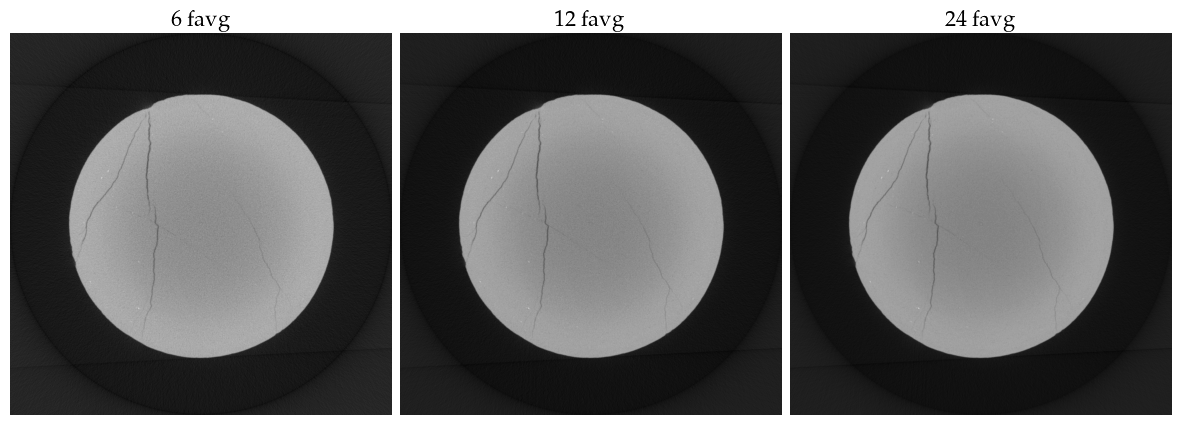

In [5]:
plot_slice_comparison(favg6_slice, favg12_slice, favg24_slice)

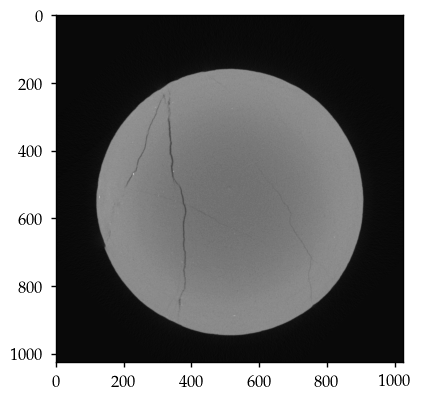

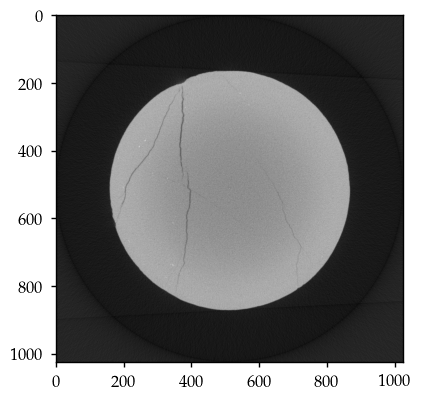

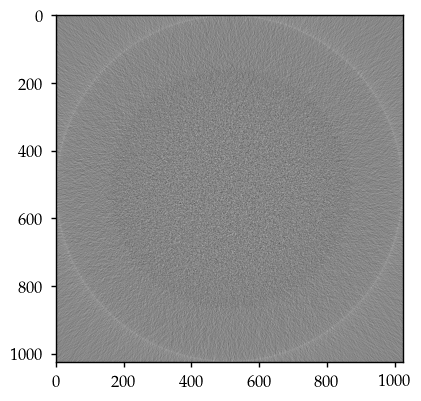

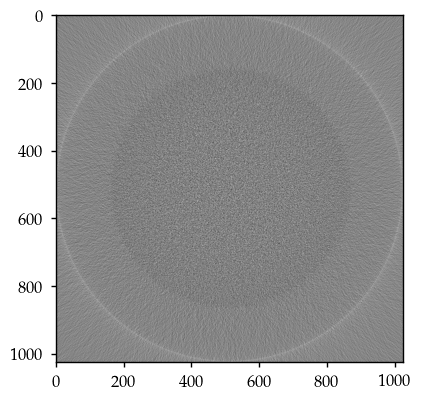

In [6]:
plt.imshow(rotated_std,cmap='gray')
plt.show()
# plt.imshow(np.abs(favg12_slice-rotated_std), cmap='gray')
# plt.show()
plt.imshow(favg6_slice, cmap='gray')
plt.show()
plt.imshow(favg12_slice-favg6_slice, cmap='gray')
plt.show()
plt.imshow(favg24_slice-favg6_slice, cmap='gray')
plt.show()

In [9]:
def gaussian(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def plot_slice_histogram(hists:list, labels:list, xlabel="Pixel Value", ylabel="Probability Density", title="Gaussian Noise", savefig=False):

    choose_formatter(False)

    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

    for hist, label in zip(hists, labels):
        ax.plot(hist, bins=400, density=True, alpha=0.5, label=label)

    # ax.hist(diff6, bins=400, density=True, alpha=0.5, label=fr"6-24: $\sigma$={np.std(diff6):.5f}")
    # ax.hist(diff12, bins=400, density=True, alpha=0.5, label=fr"12-24: $\sigma$={np.std(diff12):.5f}")
    # ax.hist(diff126, bins=400, density=True, alpha=0.5, label=fr"6-12: $\sigma$={np.std(diff126):.5f}")
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()


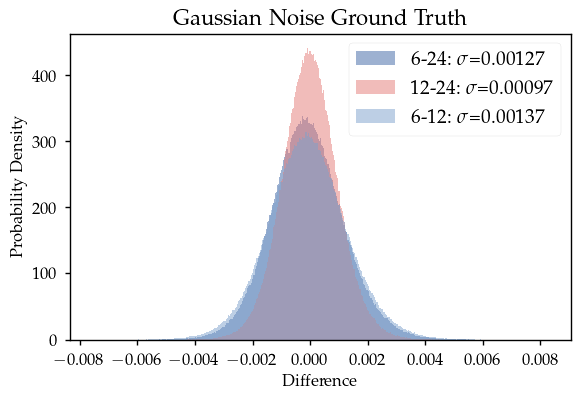

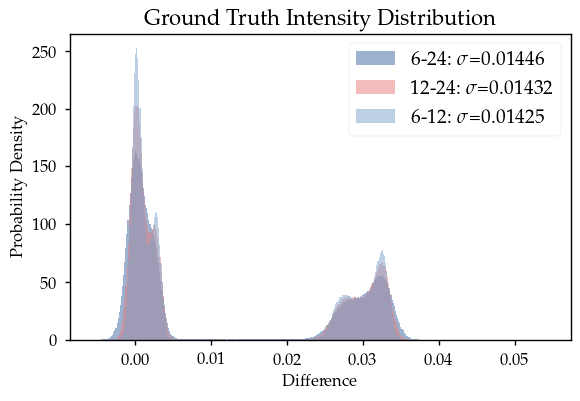

0.9987558830268889
0.9992786498365109
0.9985467672448338


In [11]:
diff6 = favg6_slice - favg24_slice
diff12 = favg12_slice - favg24_slice
diff126 = -(favg12_slice - favg6_slice)

plot_noise_histogram(diff6.flatten(), diff12.flatten(), diff126.flatten(), title="Gaussian Noise Ground Truth", savefig=False)
plot_noise_histogram(favg6_slice.flatten(), favg12_slice.flatten(), favg24_slice.flatten(), title="Ground Truth Intensity Distribution", savefig=True)


# diff126 = favg12_slice - favg6_slice

# plt.hist(diff126.flatten(), bins=400, density=True, alpha=0.5, label=fr"favg12 - favg6: $\sigma$={np.std(diff126):.5f}")
# plt.legend()
# plt.show()


print(utils.calc_ssim(favg6_slice, favg24_slice))
print(utils.calc_ssim(favg24_slice, favg12_slice))
print(utils.calc_ssim(favg12_slice, favg6_slice))